In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

## **Phase 1**
# Set data and DataLoaders  **Train:2000 , Validation:800 , Test:400**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data_dir = '/content/drive/My Drive/DataSet_for_models/train_set/'
validation_data_dir = '/content/drive/My Drive/DataSet_for_models/validation_set/'
test_data_dir = '/content/drive/My Drive/DataSet_for_models/test_set/'

train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(validation_data_dir, transform=val_transforms)
test_dataset = ImageFolder(test_data_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

##  **1**. Load Pretrained **SqueezeNet** Model

In [ ]:
model = models.squeezenet1_1(pretrained=True)

## **Modify Classifier**

In [ ]:
model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Data processing
            for inputs, labels in tqdm(dataloader):
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                #  backward pass + optimize in case of train
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Copy the best accuracy model
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    # Load the best weights into the model
    model.load_state_dict(best_model_wts)

    # Save training history
    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_squeezenet.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 200/200 [00:27<00:00,  7.40it/s]


train Loss: 1.3405 Acc: 0.3435


100%|██████████| 80/80 [00:06<00:00, 12.43it/s]


val Loss: 1.1592 Acc: 0.4725
Epoch 2/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


train Loss: 1.1798 Acc: 0.4430


100%|██████████| 80/80 [00:06<00:00, 12.66it/s]


val Loss: 1.0771 Acc: 0.4900
Epoch 3/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.52it/s]


train Loss: 1.1685 Acc: 0.4625


100%|██████████| 80/80 [00:06<00:00, 12.07it/s]


val Loss: 1.0355 Acc: 0.5563
Epoch 4/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.71it/s]


train Loss: 1.1057 Acc: 0.4940


100%|██████████| 80/80 [00:06<00:00, 12.80it/s]


val Loss: 1.2060 Acc: 0.4088
Epoch 5/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


train Loss: 1.0700 Acc: 0.5145


100%|██████████| 80/80 [00:06<00:00, 13.14it/s]


val Loss: 1.0385 Acc: 0.5300
Epoch 6/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


train Loss: 1.0389 Acc: 0.5195


100%|██████████| 80/80 [00:06<00:00, 13.25it/s]


val Loss: 1.0505 Acc: 0.5188
Epoch 7/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.81it/s]


train Loss: 0.9979 Acc: 0.5805


100%|██████████| 80/80 [00:06<00:00, 12.42it/s]


val Loss: 0.8638 Acc: 0.6613
Epoch 8/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.77it/s]


train Loss: 0.9191 Acc: 0.6185


100%|██████████| 80/80 [00:06<00:00, 13.22it/s]


val Loss: 0.9004 Acc: 0.6200
Epoch 9/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.88it/s]


train Loss: 0.8429 Acc: 0.6650


100%|██████████| 80/80 [00:06<00:00, 12.55it/s]


val Loss: 0.8427 Acc: 0.6775
Epoch 10/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


train Loss: 0.7567 Acc: 0.6950


100%|██████████| 80/80 [00:06<00:00, 12.89it/s]


val Loss: 0.6895 Acc: 0.6987
Epoch 11/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


train Loss: 0.7352 Acc: 0.7040


100%|██████████| 80/80 [00:06<00:00, 12.79it/s]


val Loss: 0.6658 Acc: 0.7300
Epoch 12/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


train Loss: 0.6144 Acc: 0.7530


100%|██████████| 80/80 [00:06<00:00, 12.95it/s]


val Loss: 0.4941 Acc: 0.8275
Epoch 13/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.73it/s]


train Loss: 0.5493 Acc: 0.7820


100%|██████████| 80/80 [00:06<00:00, 12.11it/s]


val Loss: 0.6213 Acc: 0.7963
Epoch 14/20
----------


100%|██████████| 200/200 [00:25<00:00,  7.70it/s]


train Loss: 0.4866 Acc: 0.8140


100%|██████████| 80/80 [00:06<00:00, 13.31it/s]


val Loss: 0.4189 Acc: 0.8500
Epoch 15/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


train Loss: 0.4242 Acc: 0.8435


100%|██████████| 80/80 [00:06<00:00, 12.34it/s]


val Loss: 0.4966 Acc: 0.8300
Epoch 16/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.66it/s]


train Loss: 0.4187 Acc: 0.8560


100%|██████████| 80/80 [00:06<00:00, 12.96it/s]


val Loss: 0.5695 Acc: 0.7738
Epoch 17/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.57it/s]


train Loss: 0.4405 Acc: 0.8375


100%|██████████| 80/80 [00:06<00:00, 12.53it/s]


val Loss: 0.4319 Acc: 0.8325
Epoch 18/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.53it/s]


train Loss: 0.4166 Acc: 0.8465


100%|██████████| 80/80 [00:05<00:00, 13.39it/s]


val Loss: 0.3294 Acc: 0.8838
Epoch 19/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.69it/s]


train Loss: 0.3215 Acc: 0.8740


100%|██████████| 80/80 [00:06<00:00, 12.73it/s]


val Loss: 0.3186 Acc: 0.8938
Epoch 20/20
----------


100%|██████████| 200/200 [00:26<00:00,  7.62it/s]


train Loss: 0.3402 Acc: 0.8755


100%|██████████| 80/80 [00:06<00:00, 12.91it/s]

val Loss: 0.5315 Acc: 0.8387
Best val Loss: 0.318555


## **Plot Training History**

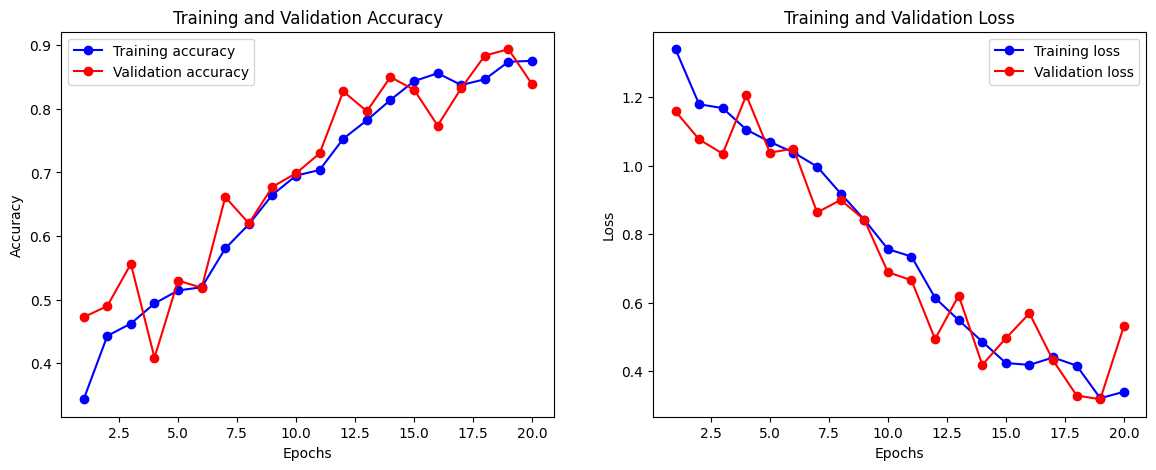

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss SqueezeNet model  : {train_loss} ... Training accuracy SqueezeNet model:   {train_accuracy}')
print(f'Validation loss SqueezeNet model: {val_loss}   ... Validation accuracy SqueezeNet model: {val_accuracy}')
print(f'Test loss SqueezeNet model      : {test_loss}  ... Test accuracy SqueezeNet model:       {test_accuracy}')


Training loss SqueezeNet model  : 0.4552689390443265 ... Training accuracy SqueezeNet model:   0.854
Validation loss SqueezeNet model: 0.5314976276298694   ... Validation accuracy SqueezeNet model: 0.83875
Test loss SqueezeNet model      : 0.4754919378068735  ... Test accuracy SqueezeNet model:       0.8275


##  **2**. Load Pretrained **EfficientNet** Model   **with 2000**

In [ ]:
model = models.efficientnet_b1(pretrained=True)

## **Modify Classifier**

In [ ]:
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_efficientnetb1.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


train Loss: 0.5915 Acc: 0.8060


100%|██████████| 80/80 [00:17<00:00,  4.61it/s]


val Loss: 0.1387 Acc: 0.9563
Epoch 2/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.3269 Acc: 0.8960


100%|██████████| 80/80 [00:17<00:00,  4.62it/s]


val Loss: 0.1411 Acc: 0.9563
Epoch 3/20
----------


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


train Loss: 0.2194 Acc: 0.9300


100%|██████████| 80/80 [00:17<00:00,  4.67it/s]


val Loss: 0.1263 Acc: 0.9688
Epoch 4/20
----------


100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


train Loss: 0.2122 Acc: 0.9330


100%|██████████| 80/80 [00:17<00:00,  4.53it/s]


val Loss: 0.2897 Acc: 0.9038
Epoch 5/20
----------


100%|██████████| 200/200 [01:55<00:00,  1.72it/s]


train Loss: 0.1386 Acc: 0.9555


100%|██████████| 80/80 [00:17<00:00,  4.62it/s]


val Loss: 0.1393 Acc: 0.9600
Epoch 6/20
----------


100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


train Loss: 0.0990 Acc: 0.9690


100%|██████████| 80/80 [00:17<00:00,  4.68it/s]


val Loss: 0.1198 Acc: 0.9675
Epoch 7/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.1129 Acc: 0.9650


100%|██████████| 80/80 [00:17<00:00,  4.49it/s]


val Loss: 0.2631 Acc: 0.9337
Epoch 8/20
----------


100%|██████████| 200/200 [02:01<00:00,  1.65it/s]


train Loss: 0.1504 Acc: 0.9600


100%|██████████| 80/80 [00:17<00:00,  4.63it/s]


val Loss: 0.1273 Acc: 0.9563
Epoch 9/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0804 Acc: 0.9750


100%|██████████| 80/80 [00:16<00:00,  4.72it/s]


val Loss: 0.0857 Acc: 0.9725
Epoch 10/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.1053 Acc: 0.9685


100%|██████████| 80/80 [00:17<00:00,  4.67it/s]


val Loss: 0.0672 Acc: 0.9800
Epoch 11/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.67it/s]


train Loss: 0.0832 Acc: 0.9755


100%|██████████| 80/80 [00:17<00:00,  4.66it/s]


val Loss: 0.0791 Acc: 0.9738
Epoch 12/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.1023 Acc: 0.9720


100%|██████████| 80/80 [00:17<00:00,  4.65it/s]


val Loss: 0.1763 Acc: 0.9550
Epoch 13/20
----------


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


train Loss: 0.0559 Acc: 0.9810


100%|██████████| 80/80 [00:17<00:00,  4.63it/s]


val Loss: 0.0450 Acc: 0.9912
Epoch 14/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0487 Acc: 0.9915


100%|██████████| 80/80 [00:17<00:00,  4.48it/s]


val Loss: 0.0908 Acc: 0.9812
Epoch 15/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0989 Acc: 0.9710


100%|██████████| 80/80 [00:17<00:00,  4.69it/s]


val Loss: 0.0911 Acc: 0.9675
Epoch 16/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0752 Acc: 0.9830


100%|██████████| 80/80 [00:17<00:00,  4.61it/s]


val Loss: 0.1502 Acc: 0.9500
Epoch 17/20
----------


100%|██████████| 200/200 [01:59<00:00,  1.67it/s]


train Loss: 0.0497 Acc: 0.9855


100%|██████████| 80/80 [00:17<00:00,  4.68it/s]


val Loss: 0.0808 Acc: 0.9825
Epoch 18/20
----------


100%|██████████| 200/200 [01:59<00:00,  1.68it/s]


train Loss: 0.0765 Acc: 0.9815


100%|██████████| 80/80 [00:17<00:00,  4.60it/s]


val Loss: 0.0385 Acc: 0.9888
Epoch 19/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0456 Acc: 0.9865


100%|██████████| 80/80 [00:17<00:00,  4.68it/s]


val Loss: 0.0582 Acc: 0.9862
Epoch 20/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.0599 Acc: 0.9860


100%|██████████| 80/80 [00:17<00:00,  4.70it/s]

val Loss: 0.0509 Acc: 0.9862
Best val Loss: 0.038536


## **Plot Training History**

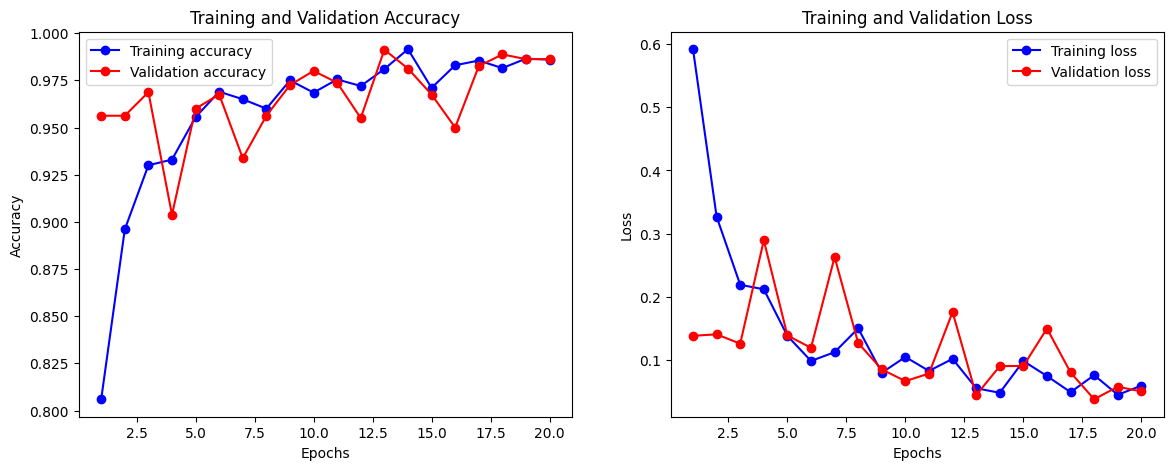

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss EfficientNetB1 model  : {train_loss} ... Training accuracy EfficientNetB1 model:   {train_accuracy}')
print(f'Validation loss EfficientNetB1 model: {val_loss}   ... Validation accuracy EfficientNetB1 model: {val_accuracy}')
print(f'Test loss EfficientNetB1 model      : {test_loss}  ... Test accuracy EfficientNetB1 model:       {test_accuracy}')

Training loss EfficientNetB1 model  : 0.012584841727784806 ... Training accuracy EfficientNetB1 model:   0.995
Validation loss EfficientNetB1 model: 0.05088280828627596   ... Validation accuracy EfficientNetB1 model: 0.98625
Test loss EfficientNetB1 model      : 0.06584195817784462  ... Test accuracy EfficientNetB1 model:       0.985


##  **3**. Load Pretrained **ShuffleNet V2** Model

In [ ]:
model = models.shufflenet_v2_x1_0(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## **Modify Classifier**

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_shufflenetv2.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.64it/s]


train Loss: 1.2489 Acc: 0.4235


100%|██████████| 80/80 [00:20<00:00,  3.91it/s]


val Loss: 1.2857 Acc: 0.4125
Epoch 2/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


train Loss: 1.1181 Acc: 0.4940


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


val Loss: 1.0008 Acc: 0.5725
Epoch 3/20
----------


100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


train Loss: 0.9057 Acc: 0.6090


100%|██████████| 80/80 [00:19<00:00,  4.15it/s]


val Loss: 0.7474 Acc: 0.7113
Epoch 4/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


train Loss: 0.7305 Acc: 0.7060


100%|██████████| 80/80 [00:19<00:00,  4.01it/s]


val Loss: 0.6509 Acc: 0.7538
Epoch 5/20
----------


100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


train Loss: 0.6618 Acc: 0.7410


100%|██████████| 80/80 [00:20<00:00,  3.88it/s]


val Loss: 0.5150 Acc: 0.8237
Epoch 6/20
----------


100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


train Loss: 0.5142 Acc: 0.8055


100%|██████████| 80/80 [00:19<00:00,  4.09it/s]


val Loss: 0.3128 Acc: 0.8850
Epoch 7/20
----------


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


train Loss: 0.4708 Acc: 0.8320


100%|██████████| 80/80 [00:20<00:00,  3.90it/s]


val Loss: 0.3613 Acc: 0.8488
Epoch 8/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


train Loss: 0.4064 Acc: 0.8500


100%|██████████| 80/80 [00:20<00:00,  3.98it/s]


val Loss: 0.3398 Acc: 0.8662
Epoch 9/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


train Loss: 0.3765 Acc: 0.8640


100%|██████████| 80/80 [00:19<00:00,  4.08it/s]


val Loss: 0.2107 Acc: 0.9300
Epoch 10/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


train Loss: 0.3179 Acc: 0.8895


100%|██████████| 80/80 [00:19<00:00,  4.08it/s]


val Loss: 0.2728 Acc: 0.9075
Epoch 11/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


train Loss: 0.2967 Acc: 0.9090


100%|██████████| 80/80 [00:20<00:00,  3.93it/s]


val Loss: 0.2074 Acc: 0.9300
Epoch 12/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.61it/s]


train Loss: 0.2498 Acc: 0.9105


100%|██████████| 80/80 [00:19<00:00,  4.01it/s]


val Loss: 0.1595 Acc: 0.9487
Epoch 13/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


train Loss: 0.2759 Acc: 0.9125


100%|██████████| 80/80 [00:19<00:00,  4.12it/s]


val Loss: 0.1903 Acc: 0.9413
Epoch 14/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


train Loss: 0.2112 Acc: 0.9285


100%|██████████| 80/80 [00:19<00:00,  4.11it/s]


val Loss: 0.2394 Acc: 0.9087
Epoch 15/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


train Loss: 0.2012 Acc: 0.9350


100%|██████████| 80/80 [00:20<00:00,  3.96it/s]


val Loss: 0.2735 Acc: 0.9263
Epoch 16/20
----------


100%|██████████| 200/200 [02:00<00:00,  1.66it/s]


train Loss: 0.1910 Acc: 0.9310


100%|██████████| 80/80 [00:20<00:00,  3.94it/s]


val Loss: 0.1620 Acc: 0.9575
Epoch 17/20
----------


100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


train Loss: 0.1764 Acc: 0.9450


100%|██████████| 80/80 [00:19<00:00,  4.00it/s]


val Loss: 0.1394 Acc: 0.9513
Epoch 18/20
----------


100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


train Loss: 0.1412 Acc: 0.9545


100%|██████████| 80/80 [00:19<00:00,  4.14it/s]


val Loss: 0.1784 Acc: 0.9487
Epoch 19/20
----------


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]


train Loss: 0.1683 Acc: 0.9470


100%|██████████| 80/80 [00:20<00:00,  3.91it/s]


val Loss: 0.1735 Acc: 0.9525
Epoch 20/20
----------


100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


train Loss: 0.1104 Acc: 0.9660


100%|██████████| 80/80 [00:20<00:00,  3.96it/s]

val Loss: 0.1950 Acc: 0.9350
Best val Loss: 0.139415


## **Plot Training History**

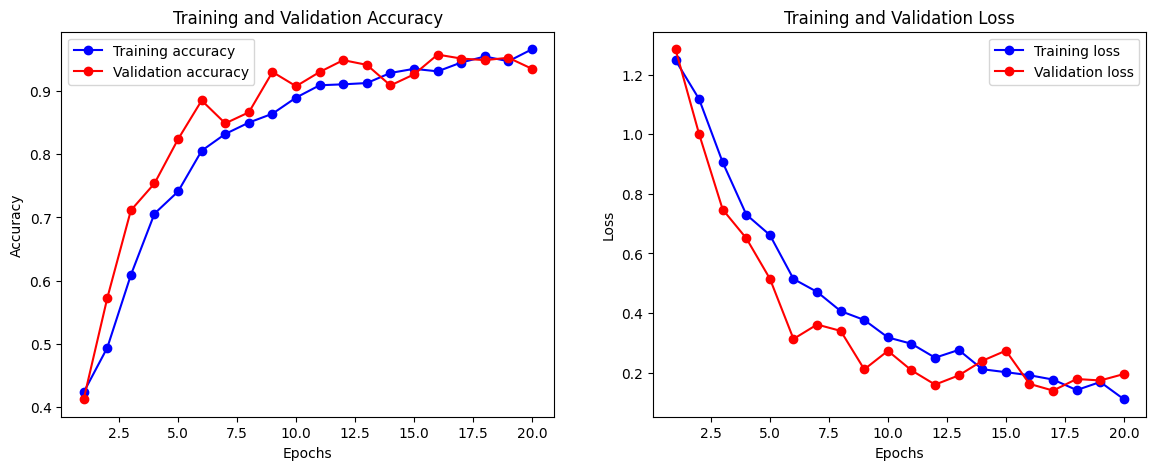

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

# Evaluate the model on train, validation, and test sets
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss ShuffleNetV2 model  : {train_loss} ... Training accuracy ShuffleNetV2 model:   {train_accuracy}')
print(f'Validation loss ShuffleNetV2 model: {val_loss}   ... Validation accuracy ShuffleNetV2 model: {val_accuracy}')
print(f'Test loss ShuffleNetV2 model      : {test_loss}  ... Test accuracy ShuffleNetV2 model:       {test_accuracy}')

Training loss ShuffleNetV2 model  : 0.08722591949277557 ... Training accuracy ShuffleNetV2 model:   0.969
Validation loss ShuffleNetV2 model: 0.19499082030135356   ... Validation accuracy ShuffleNetV2 model: 0.935
Test loss ShuffleNetV2 model      : 0.28232868108723325  ... Test accuracy ShuffleNetV2 model:       0.92


##  **4**. Load Pretrained **AlexNet** Model

In [ ]:
model = models.alexnet(pretrained=True)

## **Modify Classifier**

In [ ]:
model.classifier[6] = nn.Linear(4096, 4)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_alexnet.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history


## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 200/200 [06:26<00:00,  1.93s/it]


train Loss: 0.5264 Acc: 0.8150


100%|██████████| 80/80 [00:36<00:00,  2.18it/s]


val Loss: 0.2728 Acc: 0.9062
Epoch 2/20
----------


100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


train Loss: 0.2425 Acc: 0.9175


100%|██████████| 80/80 [00:36<00:00,  2.22it/s]


val Loss: 0.2297 Acc: 0.9075
Epoch 3/20
----------


100%|██████████| 200/200 [06:10<00:00,  1.85s/it]


train Loss: 0.1552 Acc: 0.9495


100%|██████████| 80/80 [00:36<00:00,  2.22it/s]


val Loss: 0.2401 Acc: 0.9387
Epoch 4/20
----------


100%|██████████| 200/200 [06:30<00:00,  1.95s/it]


train Loss: 0.1409 Acc: 0.9550


100%|██████████| 80/80 [00:38<00:00,  2.09it/s]


val Loss: 0.2987 Acc: 0.9213
Epoch 5/20
----------


100%|██████████| 200/200 [06:44<00:00,  2.02s/it]


train Loss: 0.1079 Acc: 0.9640


100%|██████████| 80/80 [00:36<00:00,  2.19it/s]


val Loss: 0.1723 Acc: 0.9463
Epoch 6/20
----------


100%|██████████| 200/200 [06:51<00:00,  2.06s/it]


train Loss: 0.0794 Acc: 0.9715


100%|██████████| 80/80 [00:38<00:00,  2.08it/s]


val Loss: 0.2562 Acc: 0.9487
Epoch 7/20
----------


100%|██████████| 200/200 [06:53<00:00,  2.07s/it]


train Loss: 0.1039 Acc: 0.9630


100%|██████████| 80/80 [00:36<00:00,  2.20it/s]


val Loss: 0.1913 Acc: 0.9337
Epoch 8/20
----------


100%|██████████| 200/200 [06:57<00:00,  2.09s/it]


train Loss: 0.0897 Acc: 0.9740


100%|██████████| 80/80 [00:38<00:00,  2.10it/s]


val Loss: 0.1855 Acc: 0.9425
Epoch 9/20
----------


100%|██████████| 200/200 [06:55<00:00,  2.08s/it]


train Loss: 0.0516 Acc: 0.9830


100%|██████████| 80/80 [00:37<00:00,  2.12it/s]


val Loss: 0.3875 Acc: 0.9387
Epoch 10/20
----------


100%|██████████| 200/200 [07:01<00:00,  2.11s/it]


train Loss: 0.0895 Acc: 0.9750


100%|██████████| 80/80 [00:38<00:00,  2.07it/s]


val Loss: 0.1461 Acc: 0.9650
Epoch 11/20
----------


100%|██████████| 200/200 [07:12<00:00,  2.16s/it]


train Loss: 0.0520 Acc: 0.9850


100%|██████████| 80/80 [00:37<00:00,  2.13it/s]


val Loss: 0.2124 Acc: 0.9613
Epoch 12/20
----------


100%|██████████| 200/200 [07:26<00:00,  2.23s/it]


train Loss: 0.0408 Acc: 0.9865


100%|██████████| 80/80 [00:35<00:00,  2.23it/s]


val Loss: 0.1503 Acc: 0.9625
Epoch 13/20
----------


100%|██████████| 200/200 [07:32<00:00,  2.26s/it]


train Loss: 0.0594 Acc: 0.9830


100%|██████████| 80/80 [00:37<00:00,  2.12it/s]


val Loss: 0.1602 Acc: 0.9625
Epoch 14/20
----------


100%|██████████| 200/200 [07:39<00:00,  2.30s/it]


train Loss: 0.0392 Acc: 0.9935


100%|██████████| 80/80 [00:35<00:00,  2.25it/s]


val Loss: 0.3455 Acc: 0.9263
Epoch 15/20
----------


100%|██████████| 200/200 [06:52<00:00,  2.06s/it]


train Loss: 0.0795 Acc: 0.9765


100%|██████████| 80/80 [00:36<00:00,  2.16it/s]


val Loss: 0.1737 Acc: 0.9587
Epoch 16/20
----------


100%|██████████| 200/200 [06:56<00:00,  2.08s/it]


train Loss: 0.0404 Acc: 0.9880


100%|██████████| 80/80 [00:35<00:00,  2.24it/s]


val Loss: 0.2146 Acc: 0.9525
Epoch 17/20
----------


100%|██████████| 200/200 [07:02<00:00,  2.11s/it]


train Loss: 0.0514 Acc: 0.9845


100%|██████████| 80/80 [00:35<00:00,  2.25it/s]


val Loss: 0.1016 Acc: 0.9700
Epoch 18/20
----------


100%|██████████| 200/200 [07:11<00:00,  2.16s/it]


train Loss: 0.0073 Acc: 0.9980


100%|██████████| 80/80 [00:38<00:00,  2.07it/s]


val Loss: 0.2753 Acc: 0.9463
Epoch 19/20
----------


100%|██████████| 200/200 [07:39<00:00,  2.30s/it]


train Loss: 0.0596 Acc: 0.9835


100%|██████████| 80/80 [00:37<00:00,  2.11it/s]


val Loss: 0.1965 Acc: 0.9500
Epoch 20/20
----------


100%|██████████| 200/200 [07:24<00:00,  2.22s/it]


train Loss: 0.0112 Acc: 0.9970


100%|██████████| 80/80 [00:35<00:00,  2.25it/s]

val Loss: 0.2110 Acc: 0.9525
Best val Loss: 0.101571


## **Plot Training History**

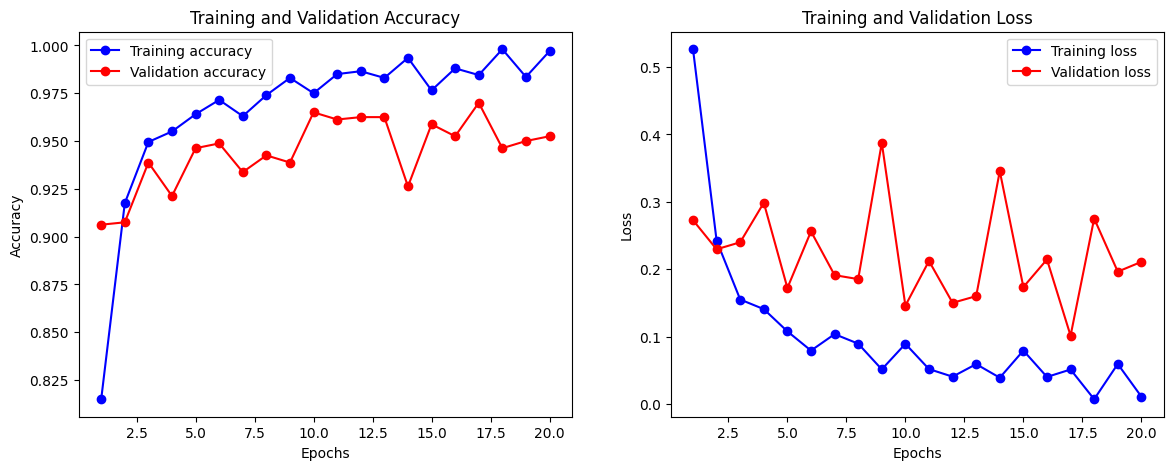

In [ ]:
# Plotting training history
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

# Evaluate the model on train, validation, and test sets
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss AlexNet model  : {train_loss} ... Training accuracy AlexNet model:   {train_accuracy}')
print(f'Validation loss AlexNet model: {val_loss}   ... Validation accuracy AlexNet model: {val_accuracy}')
print(f'Test loss AlexNet model      : {test_loss}  ... Test accuracy AlexNet model:       {test_accuracy}')


Training loss AlexNet model  : 0.008716252615595579 ... Training accuracy AlexNet model:   0.9965
Validation loss AlexNet model: 0.21102769024878623   ... Validation accuracy AlexNet model: 0.9525
Test loss AlexNet model      : 0.08482215850448753  ... Test accuracy AlexNet model:       0.9775


##  **5**. Load Pretrained **ResNext** Model

In [ ]:
model_resnext = models.resnext50_32x4d(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 148MB/s]


## **Modify Classifier**

In [ ]:
model_resnext.fc = nn.Sequential(
    nn.Linear(model_resnext.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model_resnext.parameters():
    param.requires_grad = True


##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnext.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_resnext.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnext = model_resnext.to(device)
model_resnext, history = train_model(model_resnext, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 200/200 [08:07<00:00,  2.44s/it]


train Loss: 1.0380 Acc: 0.5670


100%|██████████| 80/80 [03:06<00:00,  2.33s/it]


val Loss: 0.6937 Acc: 0.6900
Epoch 2/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


train Loss: 0.7032 Acc: 0.7185


100%|██████████| 80/80 [00:13<00:00,  5.84it/s]


val Loss: 0.5438 Acc: 0.8100
Epoch 3/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


train Loss: 0.6096 Acc: 0.7800


100%|██████████| 80/80 [00:14<00:00,  5.55it/s]


val Loss: 0.4299 Acc: 0.8462
Epoch 4/20
----------


100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


train Loss: 0.5471 Acc: 0.7975


100%|██████████| 80/80 [00:13<00:00,  5.79it/s]


val Loss: 0.3470 Acc: 0.8962
Epoch 5/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


train Loss: 0.4481 Acc: 0.8485


100%|██████████| 80/80 [00:13<00:00,  5.86it/s]


val Loss: 0.6660 Acc: 0.7925
Epoch 6/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


train Loss: 0.4186 Acc: 0.8605


100%|██████████| 80/80 [00:13<00:00,  5.84it/s]


val Loss: 0.2747 Acc: 0.9075
Epoch 7/20
----------


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


train Loss: 0.3398 Acc: 0.8790


100%|██████████| 80/80 [00:13<00:00,  5.89it/s]


val Loss: 0.6467 Acc: 0.8063
Epoch 8/20
----------


100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


train Loss: 0.3441 Acc: 0.8860


100%|██████████| 80/80 [00:13<00:00,  5.78it/s]


val Loss: 0.3117 Acc: 0.8975
Epoch 9/20
----------


100%|██████████| 200/200 [01:33<00:00,  2.15it/s]


train Loss: 0.3210 Acc: 0.8940


100%|██████████| 80/80 [00:13<00:00,  5.77it/s]


val Loss: 0.2918 Acc: 0.9175
Epoch 10/20
----------


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


train Loss: 0.3077 Acc: 0.9015


100%|██████████| 80/80 [00:13<00:00,  5.93it/s]


val Loss: 0.2372 Acc: 0.9275
Epoch 11/20
----------


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


train Loss: 0.3194 Acc: 0.9000


100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


val Loss: 0.1373 Acc: 0.9500
Epoch 12/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


train Loss: 0.2936 Acc: 0.9005


100%|██████████| 80/80 [00:13<00:00,  5.73it/s]


val Loss: 0.3482 Acc: 0.8425
Epoch 13/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


train Loss: 0.2376 Acc: 0.9180


100%|██████████| 80/80 [00:13<00:00,  5.83it/s]


val Loss: 0.1425 Acc: 0.9613
Epoch 14/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


train Loss: 0.2217 Acc: 0.9295


100%|██████████| 80/80 [00:13<00:00,  5.94it/s]


val Loss: 0.1690 Acc: 0.9450
Epoch 15/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


train Loss: 0.2317 Acc: 0.9310


100%|██████████| 80/80 [00:13<00:00,  6.01it/s]


val Loss: 0.2440 Acc: 0.9225
Epoch 16/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


train Loss: 0.1922 Acc: 0.9320


100%|██████████| 80/80 [00:14<00:00,  5.69it/s]


val Loss: 0.1151 Acc: 0.9613
Epoch 17/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


train Loss: 0.1997 Acc: 0.9380


100%|██████████| 80/80 [00:13<00:00,  5.87it/s]


val Loss: 0.1508 Acc: 0.9450
Epoch 18/20
----------


100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


train Loss: 0.1787 Acc: 0.9505


100%|██████████| 80/80 [00:13<00:00,  5.89it/s]


val Loss: 0.2123 Acc: 0.9437
Epoch 19/20
----------


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


train Loss: 0.1957 Acc: 0.9430


100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


val Loss: 0.1496 Acc: 0.9437
Epoch 20/20
----------


100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


train Loss: 0.1960 Acc: 0.9415


100%|██████████| 80/80 [00:13<00:00,  5.82it/s]

val Loss: 0.3336 Acc: 0.9062
Best val Loss: 0.115090


## **Plot Training History**

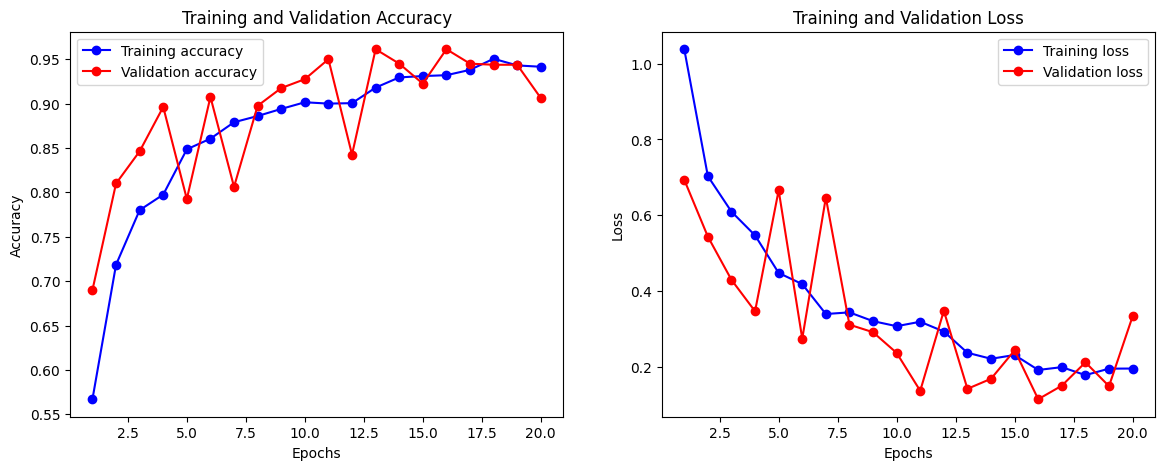

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

train_loss, train_accuracy = evaluate_model(model_resnext, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model_resnext, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model_resnext, test_loader, criterion)

print(f'Training loss ResNeXt model  : {train_loss} ... Training accuracy ResNeXt model:   {train_accuracy}')
print(f'Validation loss ResNeXt model: {val_loss}   ... Validation accuracy ResNeXt model: {val_accuracy}')
print(f'Test loss ResNeXt model      : {test_loss}  ... Test accuracy ResNeXt model:       {test_accuracy}')


Training loss ResNeXt model  : 0.2247833357687341 ... Training accuracy ResNeXt model:   0.9355
Validation loss ResNeXt model: 0.33358771962666084   ... Validation accuracy ResNeXt model: 0.90625
Test loss ResNeXt model      : 0.3543455061247528  ... Test accuracy ResNeXt model:       0.89


## **Phase 2**
# Set data and DataLoaders  **Train:1000 , Validation:400 , Test:200**

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data_dir =     '/content/drive/My Drive/DataSet_1000_for_models/train_set/'
validation_data_dir ='/content/drive/My Drive/DataSet_1000_for_models/validation_set/'
test_dir =           '/content/drive/My Drive/DataSet_1000_for_models/test_set/'


train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(validation_data_dir, transform=val_transforms)
test_dataset = ImageFolder(test_data_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

##  **1**. Load Pretrained **EfficientNet** Model   **with 1000**

In [ ]:
model_efficientnet = models.efficientnet_b1(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 162MB/s] 


## **Modify Classifier**

In [ ]:
model_efficientnet.classifier = nn.Sequential(
    nn.Linear(model_efficientnet.classifier[1].in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model_efficientnet.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_efficientnetb1.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
model_efficientnet, history = train_model(model_efficientnet, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 100/100 [04:07<00:00,  2.47s/it]


train Loss: 0.7093 Acc: 0.7370


100%|██████████| 40/40 [01:34<00:00,  2.37s/it]


val Loss: 0.1685 Acc: 0.9375
Epoch 2/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.4763 Acc: 0.8470


100%|██████████| 40/40 [00:08<00:00,  4.82it/s]


val Loss: 0.2366 Acc: 0.9300
Epoch 3/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


train Loss: 0.3071 Acc: 0.8930


100%|██████████| 40/40 [00:08<00:00,  4.75it/s]


val Loss: 0.1584 Acc: 0.9350
Epoch 4/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.2581 Acc: 0.9210


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 0.1603 Acc: 0.9400
Epoch 5/20
----------


100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


train Loss: 0.2115 Acc: 0.9280


100%|██████████| 40/40 [00:08<00:00,  4.70it/s]


val Loss: 0.1889 Acc: 0.9475
Epoch 6/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


train Loss: 0.2536 Acc: 0.9370


100%|██████████| 40/40 [00:08<00:00,  4.79it/s]


val Loss: 0.2685 Acc: 0.9300
Epoch 7/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.1584 Acc: 0.9550


100%|██████████| 40/40 [00:08<00:00,  4.78it/s]


val Loss: 0.1520 Acc: 0.9450
Epoch 8/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


train Loss: 0.0677 Acc: 0.9750


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 0.0471 Acc: 0.9875
Epoch 9/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


train Loss: 0.0912 Acc: 0.9780


100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


val Loss: 0.0882 Acc: 0.9725
Epoch 10/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.1650 Acc: 0.9560


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 0.2272 Acc: 0.9150
Epoch 11/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.1819 Acc: 0.9520


100%|██████████| 40/40 [00:08<00:00,  4.67it/s]


val Loss: 0.1377 Acc: 0.9700
Epoch 12/20
----------


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


train Loss: 0.0954 Acc: 0.9680


100%|██████████| 40/40 [00:08<00:00,  4.76it/s]


val Loss: 0.1736 Acc: 0.9550
Epoch 13/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


train Loss: 0.0839 Acc: 0.9750


100%|██████████| 40/40 [00:08<00:00,  4.76it/s]


val Loss: 0.1940 Acc: 0.9450
Epoch 14/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


train Loss: 0.1447 Acc: 0.9650


100%|██████████| 40/40 [00:08<00:00,  4.67it/s]


val Loss: 0.0883 Acc: 0.9675
Epoch 15/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


train Loss: 0.0601 Acc: 0.9840


100%|██████████| 40/40 [00:08<00:00,  4.71it/s]


val Loss: 0.1119 Acc: 0.9725
Epoch 16/20
----------


100%|██████████| 100/100 [00:57<00:00,  1.72it/s]


train Loss: 0.0501 Acc: 0.9870


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 0.0707 Acc: 0.9825
Epoch 17/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


train Loss: 0.0101 Acc: 0.9970


100%|██████████| 40/40 [00:08<00:00,  4.83it/s]


val Loss: 0.0715 Acc: 0.9900
Epoch 18/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


train Loss: 0.0025 Acc: 0.9990


100%|██████████| 40/40 [00:08<00:00,  4.81it/s]


val Loss: 0.0773 Acc: 0.9900
Epoch 19/20
----------


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


train Loss: 0.0030 Acc: 0.9990


100%|██████████| 40/40 [00:08<00:00,  4.72it/s]


val Loss: 0.0728 Acc: 0.9900
Epoch 20/20
----------


100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


train Loss: 0.0034 Acc: 0.9990


100%|██████████| 40/40 [00:08<00:00,  4.69it/s]


val Loss: 0.0706 Acc: 0.9900
Best val Loss: 0.047124


## **Plot Training History**

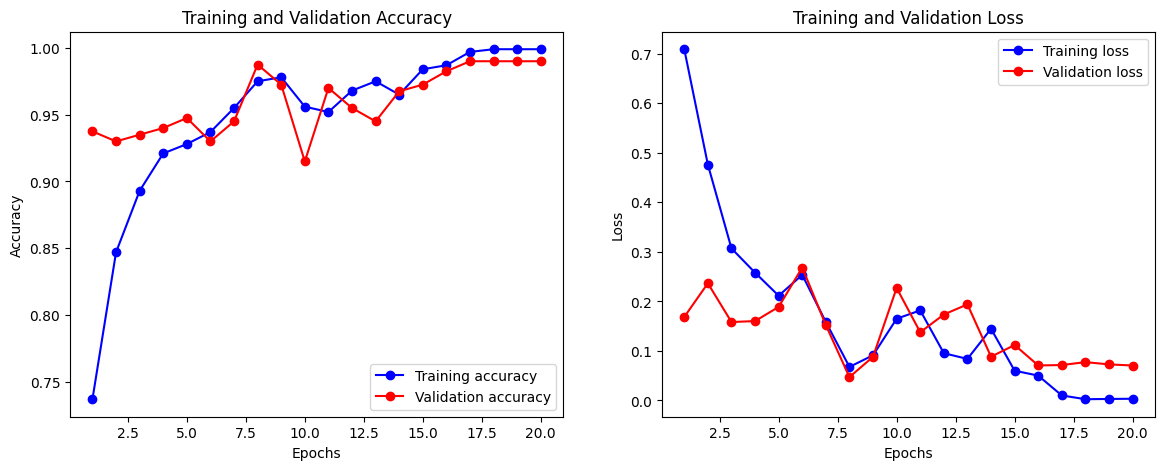

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

train_loss, train_accuracy = evaluate_model(model_efficientnet, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model_efficientnet, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model_efficientnet, test_loader, criterion)

print(f'Training loss EfficientNetB1 model  : {train_loss} ... Training accuracy EfficientNetB1 model:   {train_accuracy}')
print(f'Validation loss EfficientNetB1 model: {val_loss}   ... Validation accuracy EfficientNetB1 model: {val_accuracy}')
print(f'Test loss EfficientNetB1 model      : {test_loss}  ... Test accuracy EfficientNetB1 model:       {test_accuracy}')

Training loss EfficientNetB1 model  : 4.2243574671374515e-05 ... Training accuracy EfficientNetB1 model:   1.0
Validation loss EfficientNetB1 model: 0.07055757262087355   ... Validation accuracy EfficientNetB1 model: 0.99
Test loss EfficientNetB1 model      : 0.0813900587703074  ... Test accuracy EfficientNetB1 model:       0.9825


##  **2**. Load Pretrained **ShuffleNet V2** Model   with **1000**

In [ ]:
model = models.shufflenet_v2_x1_0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 90.9MB/s]


## **Modify Classifier**

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_shufflenetv2.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.69it/s]


train Loss: 0.8085 Acc: 0.6970


100%|██████████| 40/40 [00:04<00:00,  9.84it/s]


val Loss: 0.3032 Acc: 0.8825
Epoch 2/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


train Loss: 0.3895 Acc: 0.8870


100%|██████████| 40/40 [00:04<00:00,  9.56it/s]


val Loss: 0.2416 Acc: 0.9400
Epoch 3/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


train Loss: 0.3326 Acc: 0.9010


100%|██████████| 40/40 [00:04<00:00,  9.50it/s]


val Loss: 0.1626 Acc: 0.9600
Epoch 4/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.66it/s]


train Loss: 0.2357 Acc: 0.9240


100%|██████████| 40/40 [00:04<00:00,  9.55it/s]


val Loss: 0.1383 Acc: 0.9600
Epoch 5/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


train Loss: 0.2212 Acc: 0.9230


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]


val Loss: 0.1509 Acc: 0.9675
Epoch 6/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


train Loss: 0.1625 Acc: 0.9460


100%|██████████| 40/40 [00:04<00:00,  9.63it/s]


val Loss: 0.1168 Acc: 0.9550
Epoch 7/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


train Loss: 0.1164 Acc: 0.9580


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


val Loss: 0.2149 Acc: 0.9400
Epoch 8/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


train Loss: 0.1976 Acc: 0.9340


100%|██████████| 40/40 [00:04<00:00,  9.33it/s]


val Loss: 0.1157 Acc: 0.9700
Epoch 9/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


train Loss: 0.1162 Acc: 0.9680


100%|██████████| 40/40 [00:04<00:00,  9.64it/s]


val Loss: 0.0919 Acc: 0.9750
Epoch 10/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.73it/s]


train Loss: 0.0875 Acc: 0.9740


100%|██████████| 40/40 [00:04<00:00,  9.80it/s]


val Loss: 0.0928 Acc: 0.9775
Epoch 11/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


train Loss: 0.0496 Acc: 0.9840


100%|██████████| 40/40 [00:04<00:00,  9.59it/s]


val Loss: 0.0901 Acc: 0.9700
Epoch 12/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


train Loss: 0.0849 Acc: 0.9750


100%|██████████| 40/40 [00:04<00:00,  9.87it/s]


val Loss: 0.1847 Acc: 0.9450
Epoch 13/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


train Loss: 0.1682 Acc: 0.9570


100%|██████████| 40/40 [00:03<00:00, 10.55it/s]


val Loss: 0.1133 Acc: 0.9700
Epoch 14/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


train Loss: 0.0660 Acc: 0.9850


100%|██████████| 40/40 [00:03<00:00, 10.39it/s]


val Loss: 0.1477 Acc: 0.9525
Epoch 15/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


train Loss: 0.0842 Acc: 0.9730


100%|██████████| 40/40 [00:03<00:00, 10.66it/s]


val Loss: 0.0805 Acc: 0.9700
Epoch 16/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


train Loss: 0.0673 Acc: 0.9790


100%|██████████| 40/40 [00:03<00:00, 10.22it/s]


val Loss: 0.0827 Acc: 0.9750
Epoch 17/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


train Loss: 0.0639 Acc: 0.9790


100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


val Loss: 0.0736 Acc: 0.9725
Epoch 18/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


train Loss: 0.0553 Acc: 0.9820


100%|██████████| 40/40 [00:03<00:00, 10.33it/s]


val Loss: 0.1646 Acc: 0.9600
Epoch 19/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


train Loss: 0.0964 Acc: 0.9740


100%|██████████| 40/40 [00:03<00:00, 10.35it/s]


val Loss: 0.1130 Acc: 0.9600
Epoch 20/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


train Loss: 0.0589 Acc: 0.9810


100%|██████████| 40/40 [00:03<00:00, 10.05it/s]


val Loss: 0.1031 Acc: 0.9725
Best val Loss: 0.073586


## **Plot Training History**

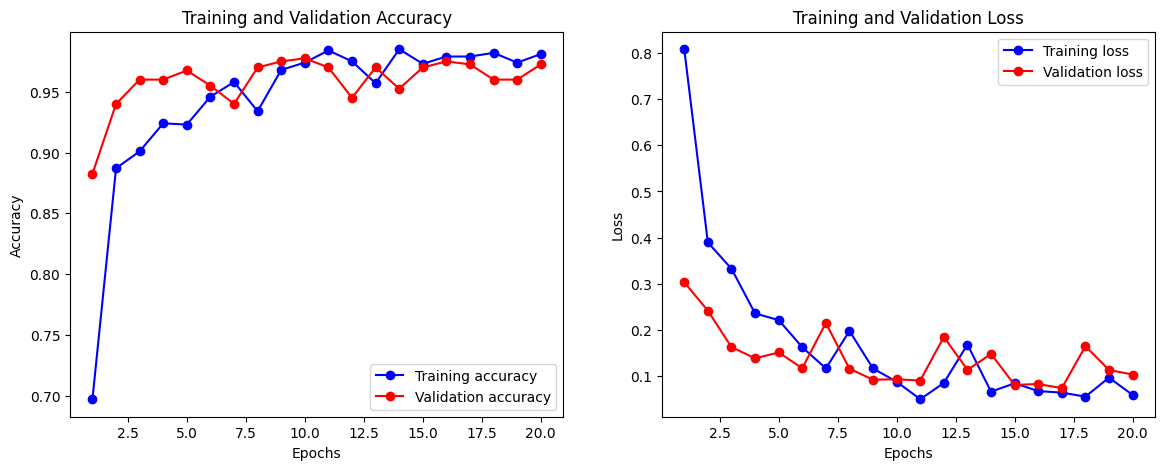

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

# Evaluate the model on train, validation, and test sets
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss ShuffleNetV2 model  : {train_loss} ... Training accuracy ShuffleNetV2 model:   {train_accuracy}')
print(f'Validation loss ShuffleNetV2 model: {val_loss}   ... Validation accuracy ShuffleNetV2 model: {val_accuracy}')
print(f'Test loss ShuffleNetV2 model      : {test_loss}  ... Test accuracy ShuffleNetV2 model:       {test_accuracy}')

Training loss ShuffleNetV2 model  : 0.007486753109114943 ... Training accuracy ShuffleNetV2 model:   0.998
Validation loss ShuffleNetV2 model: 0.10308015971395434   ... Validation accuracy ShuffleNetV2 model: 0.9725
Test loss ShuffleNetV2 model      : 0.15069811906178074  ... Test accuracy ShuffleNetV2 model:       0.96


##  **3**. Load Pretrained **AlexNet** Model  with **1000**

In [ ]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 230MB/s]


## **Modify Classifier**

In [ ]:
model.classifier[6] = nn.Linear(4096, 4)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_alexnet.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history


## Model Train

In [ ]:
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


train Loss: 0.6319 Acc: 0.7690


100%|██████████| 40/40 [00:02<00:00, 13.90it/s]


val Loss: 0.4315 Acc: 0.8600
Epoch 2/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


train Loss: 0.3583 Acc: 0.8860


100%|██████████| 40/40 [00:03<00:00, 13.30it/s]


val Loss: 0.1831 Acc: 0.9425
Epoch 3/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


train Loss: 0.1932 Acc: 0.9350


100%|██████████| 40/40 [00:02<00:00, 13.64it/s]


val Loss: 0.2693 Acc: 0.9100
Epoch 4/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.25it/s]


train Loss: 0.1809 Acc: 0.9550


100%|██████████| 40/40 [00:02<00:00, 14.44it/s]


val Loss: 0.1920 Acc: 0.9350
Epoch 5/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


train Loss: 0.1197 Acc: 0.9640


100%|██████████| 40/40 [00:02<00:00, 13.71it/s]


val Loss: 0.3349 Acc: 0.8900
Epoch 6/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


train Loss: 0.1118 Acc: 0.9650


100%|██████████| 40/40 [00:02<00:00, 13.99it/s]


val Loss: 0.2943 Acc: 0.9475
Epoch 7/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


train Loss: 0.0707 Acc: 0.9680


100%|██████████| 40/40 [00:02<00:00, 14.15it/s]


val Loss: 0.1853 Acc: 0.9325
Epoch 8/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.14it/s]


train Loss: 0.0953 Acc: 0.9730


100%|██████████| 40/40 [00:03<00:00, 12.93it/s]


val Loss: 0.1446 Acc: 0.9475
Epoch 9/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


train Loss: 0.0950 Acc: 0.9680


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


val Loss: 0.4331 Acc: 0.9075
Epoch 10/20
----------


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


train Loss: 0.0999 Acc: 0.9740


100%|██████████| 40/40 [00:02<00:00, 13.61it/s]


val Loss: 0.1714 Acc: 0.9500
Epoch 11/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


train Loss: 0.0772 Acc: 0.9730


100%|██████████| 40/40 [00:02<00:00, 14.52it/s]


val Loss: 0.4827 Acc: 0.9175
Epoch 12/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.17it/s]


train Loss: 0.0461 Acc: 0.9860


100%|██████████| 40/40 [00:02<00:00, 14.38it/s]


val Loss: 0.1336 Acc: 0.9625
Epoch 13/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


train Loss: 0.0430 Acc: 0.9890


100%|██████████| 40/40 [00:02<00:00, 13.84it/s]


val Loss: 0.1287 Acc: 0.9625
Epoch 14/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.10it/s]


train Loss: 0.0436 Acc: 0.9870


100%|██████████| 40/40 [00:02<00:00, 13.82it/s]


val Loss: 0.2208 Acc: 0.9500
Epoch 15/20
----------


100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


train Loss: 0.0306 Acc: 0.9940


100%|██████████| 40/40 [00:02<00:00, 14.33it/s]


val Loss: 0.2859 Acc: 0.9375
Epoch 16/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


train Loss: 0.0698 Acc: 0.9770


100%|██████████| 40/40 [00:03<00:00, 13.31it/s]


val Loss: 0.1802 Acc: 0.9675
Epoch 17/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


train Loss: 0.0915 Acc: 0.9760


100%|██████████| 40/40 [00:02<00:00, 13.42it/s]


val Loss: 0.1961 Acc: 0.9575
Epoch 18/20
----------


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


train Loss: 0.0048 Acc: 1.0000


100%|██████████| 40/40 [00:02<00:00, 13.44it/s]


val Loss: 0.1323 Acc: 0.9750
Epoch 19/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.62it/s]


train Loss: 0.0263 Acc: 0.9960


100%|██████████| 40/40 [00:02<00:00, 13.70it/s]


val Loss: 0.1610 Acc: 0.9625
Epoch 20/20
----------


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


train Loss: 0.0162 Acc: 0.9930


100%|██████████| 40/40 [00:02<00:00, 14.23it/s]


val Loss: 0.1908 Acc: 0.9400
Best val Loss: 0.128690


## **Plot Training History**

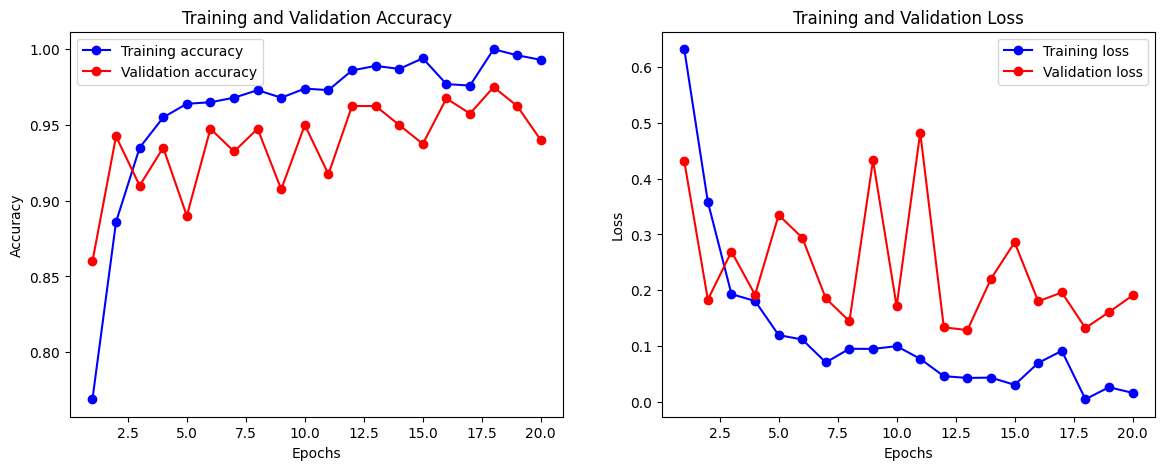

In [ ]:
# Plotting training history
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

# Evaluate the model on train, validation, and test sets
train_loss, train_accuracy = evaluate_model(model, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)

print(f'Training loss AlexNet model  : {train_loss} ... Training accuracy AlexNet model:   {train_accuracy}')
print(f'Validation loss AlexNet model: {val_loss}   ... Validation accuracy AlexNet model: {val_accuracy}')
print(f'Test loss AlexNet model      : {test_loss}  ... Test accuracy AlexNet model:       {test_accuracy}')


Training loss AlexNet model  : 0.006535650623814036 ... Training accuracy AlexNet model:   0.998
Validation loss AlexNet model: 0.19078432930112166   ... Validation accuracy AlexNet model: 0.94
Test loss AlexNet model      : 0.43401927129808937  ... Test accuracy AlexNet model:       0.925


##  **4**. Load Pretrained **ResNext** Model  with **1000**

In [ ]:
model_resnext = models.resnext50_32x4d(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_resnext.fc = nn.Sequential(
    nn.Linear(model_resnext.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)

## Set Requires Grad: **The parameters of the model are set to be able to be train**

In [ ]:
for param in model_resnext.parameters():
    param.requires_grad = True


##  Define **Loss Function** and **Optimizer**  and **Configure Learning Rate** Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnext.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=7, min_lr=0.00001)

## Model **training function**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_model_wts = model.state_dict()
    best_loss = float('inf')
    patience = 15
    patience_counter = 0

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping")
            break

    print('Best val Loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)

    history = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    with open('/content/drive/My Drive/History_Train_Models/history_resnext.pkl', 'wb') as file:
        pickle.dump(history, file)

    return model, history

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnext = model_resnext.to(device)
model_resnext, history = train_model(model_resnext, criterion, optimizer, scheduler, num_epochs=20)

Epoch 1/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 1.2759 Acc: 0.4590


100%|██████████| 40/40 [00:07<00:00,  5.51it/s]


val Loss: 3.9911 Acc: 0.4675
Epoch 2/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.9364 Acc: 0.5870


100%|██████████| 40/40 [00:06<00:00,  5.94it/s]


val Loss: 1.0634 Acc: 0.6025
Epoch 3/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


train Loss: 0.7540 Acc: 0.7070


100%|██████████| 40/40 [00:07<00:00,  5.56it/s]


val Loss: 0.8512 Acc: 0.6875
Epoch 4/20
----------


100%|██████████| 100/100 [00:47<00:00,  2.13it/s]


train Loss: 0.7202 Acc: 0.7300


100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


val Loss: 0.4975 Acc: 0.7975
Epoch 5/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.6413 Acc: 0.7470


100%|██████████| 40/40 [00:06<00:00,  6.03it/s]


val Loss: 0.4231 Acc: 0.8250
Epoch 6/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


train Loss: 0.5431 Acc: 0.8140


100%|██████████| 40/40 [00:06<00:00,  5.87it/s]


val Loss: 0.5439 Acc: 0.8025
Epoch 7/20
----------


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


train Loss: 0.4913 Acc: 0.8320


100%|██████████| 40/40 [00:06<00:00,  6.00it/s]


val Loss: 0.3275 Acc: 0.8725
Epoch 8/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


train Loss: 0.4721 Acc: 0.8290


100%|██████████| 40/40 [00:06<00:00,  5.73it/s]


val Loss: 0.3929 Acc: 0.8525
Epoch 9/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.4654 Acc: 0.8230


100%|██████████| 40/40 [00:07<00:00,  5.41it/s]


val Loss: 0.5136 Acc: 0.8250
Epoch 10/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


train Loss: 0.5189 Acc: 0.8250


100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


val Loss: 0.3240 Acc: 0.9050
Epoch 11/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.4424 Acc: 0.8550


100%|██████████| 40/40 [00:06<00:00,  5.74it/s]


val Loss: 0.2570 Acc: 0.9150
Epoch 12/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


train Loss: 0.3996 Acc: 0.8690


100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


val Loss: 1.0322 Acc: 0.7300
Epoch 13/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.4576 Acc: 0.8610


100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


val Loss: 0.3383 Acc: 0.8950
Epoch 14/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


train Loss: 0.3905 Acc: 0.8750


100%|██████████| 40/40 [00:06<00:00,  5.74it/s]


val Loss: 0.2970 Acc: 0.8925
Epoch 15/20
----------


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


train Loss: 0.2900 Acc: 0.9020


100%|██████████| 40/40 [00:07<00:00,  5.40it/s]


val Loss: 0.2015 Acc: 0.9300
Epoch 16/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


train Loss: 0.2688 Acc: 0.8990


100%|██████████| 40/40 [00:06<00:00,  5.84it/s]


val Loss: 0.2613 Acc: 0.9275
Epoch 17/20
----------


100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


train Loss: 0.3534 Acc: 0.8790


100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


val Loss: 0.2905 Acc: 0.8950
Epoch 18/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


train Loss: 0.2806 Acc: 0.9100


100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


val Loss: 0.2473 Acc: 0.9000
Epoch 19/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


train Loss: 0.2774 Acc: 0.9160


100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


val Loss: 0.3737 Acc: 0.9025
Epoch 20/20
----------


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


train Loss: 0.3503 Acc: 0.8680


100%|██████████| 40/40 [00:07<00:00,  5.66it/s]


val Loss: 0.2823 Acc: 0.9075
Best val Loss: 0.201532


## **Plot Training History**

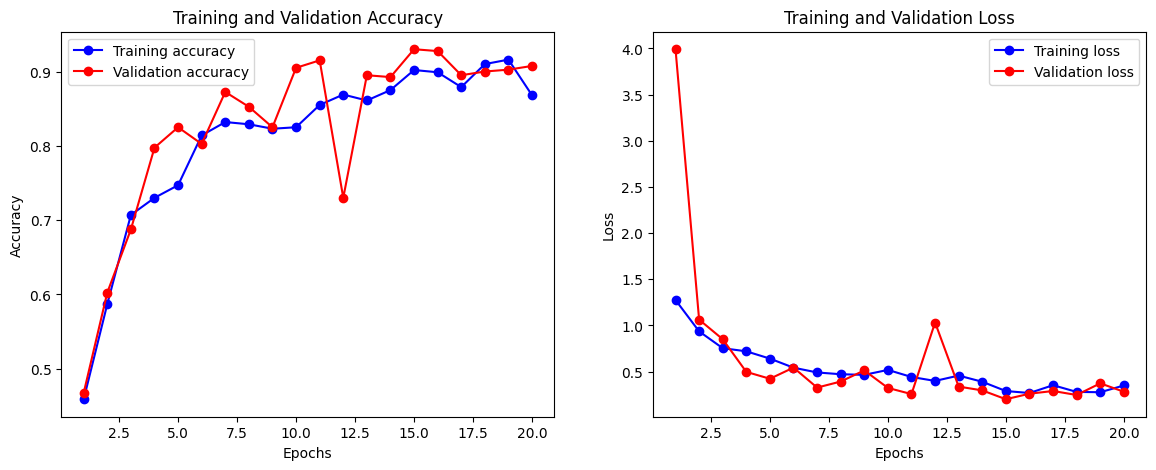

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_accuracy'], 'bo-', label='Training accuracy')
plt.plot(epochs, history['val_accuracy'], 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'bo-', label='Training loss')
plt.plot(epochs, history['val_loss'], 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## **Evaluate the Model**

In [ ]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / len(dataloader.dataset)
    total_accuracy = running_corrects.double() / len(dataloader.dataset)

    return total_loss, total_accuracy

train_loss, train_accuracy = evaluate_model(model_resnext, train_loader, criterion)
val_loss, val_accuracy = evaluate_model(model_resnext, val_loader, criterion)
test_loss, test_accuracy = evaluate_model(model_resnext, test_loader, criterion)

print(f'Training loss ResNeXt model  : {train_loss} ... Training accuracy ResNeXt model:   {train_accuracy}')
print(f'Validation loss ResNeXt model: {val_loss}   ... Validation accuracy ResNeXt model: {val_accuracy}')
print(f'Test loss ResNeXt model      : {test_loss}  ... Test accuracy ResNeXt model:       {test_accuracy}')


Training loss ResNeXt model  : 0.1269377200002782 ... Training accuracy ResNeXt model:   0.965
Validation loss ResNeXt model: 0.28232664808874686   ... Validation accuracy ResNeXt model: 0.9075
Test loss ResNeXt model      : 0.2115772125449439  ... Test accuracy ResNeXt model:       0.9325
